In [75]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 8 (INSECTS-incremental_balanced_norm.csv Data)
#
# Author: Chanchal Chatterjee
#

In [76]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf


In [77]:
# Data obtained from USP DS Repository https://sites.google.com/view/uspdsrepository
# Load the data in your unique bucket.
# Here gs://chanchal_book_bucket1/INSECTS-incremental_balanced_norm.csv

In [78]:
#get data here: https://sites.google.com/view/uspdsrepository
dataset   = pd.read_csv("gs://chanchal_book_bucket1/INSECTS-incremental_balanced_norm.csv")
dataset = dataset.dropna()
print(dataset.shape)
print(dataset.head())


(57018, 34)
         F1        F2        F3        F4        F5        F6        F7  \
0  0.162919  0.223581  0.170982  0.210447  0.260262  0.313684  0.210527   
1  0.179910  0.015617  0.018342  0.111462  0.028435  0.164292  0.105495   
2  0.093009  0.171964  0.103600  0.193611  0.206219  0.260224  0.183089   
3  0.364570  0.120045  0.186800  0.226773  0.280583  0.335924  0.229092   
4  0.257008  0.353529  0.007418  0.330596  0.027673  0.239377  0.283919   

         F8        F9       F10  ...       F25       F26       F27       F28  \
0  0.129912  0.108045  0.314143  ...  0.184005  0.107587  0.029085  0.019693   
1  0.085920  0.079683  0.048566  ...  0.008929  0.016024  0.024117  0.021911   
2  0.275424  0.240193  0.236459  ...  0.030383  0.024538  0.023142  0.027263   
3  0.217283  0.212943  0.101705  ...  0.032920  0.181381  0.292963  0.176154   
4  0.036563  0.088543  0.056334  ...  0.007628  0.009555  0.005842  0.019820   

        F29       F30       F31       F32       F33     

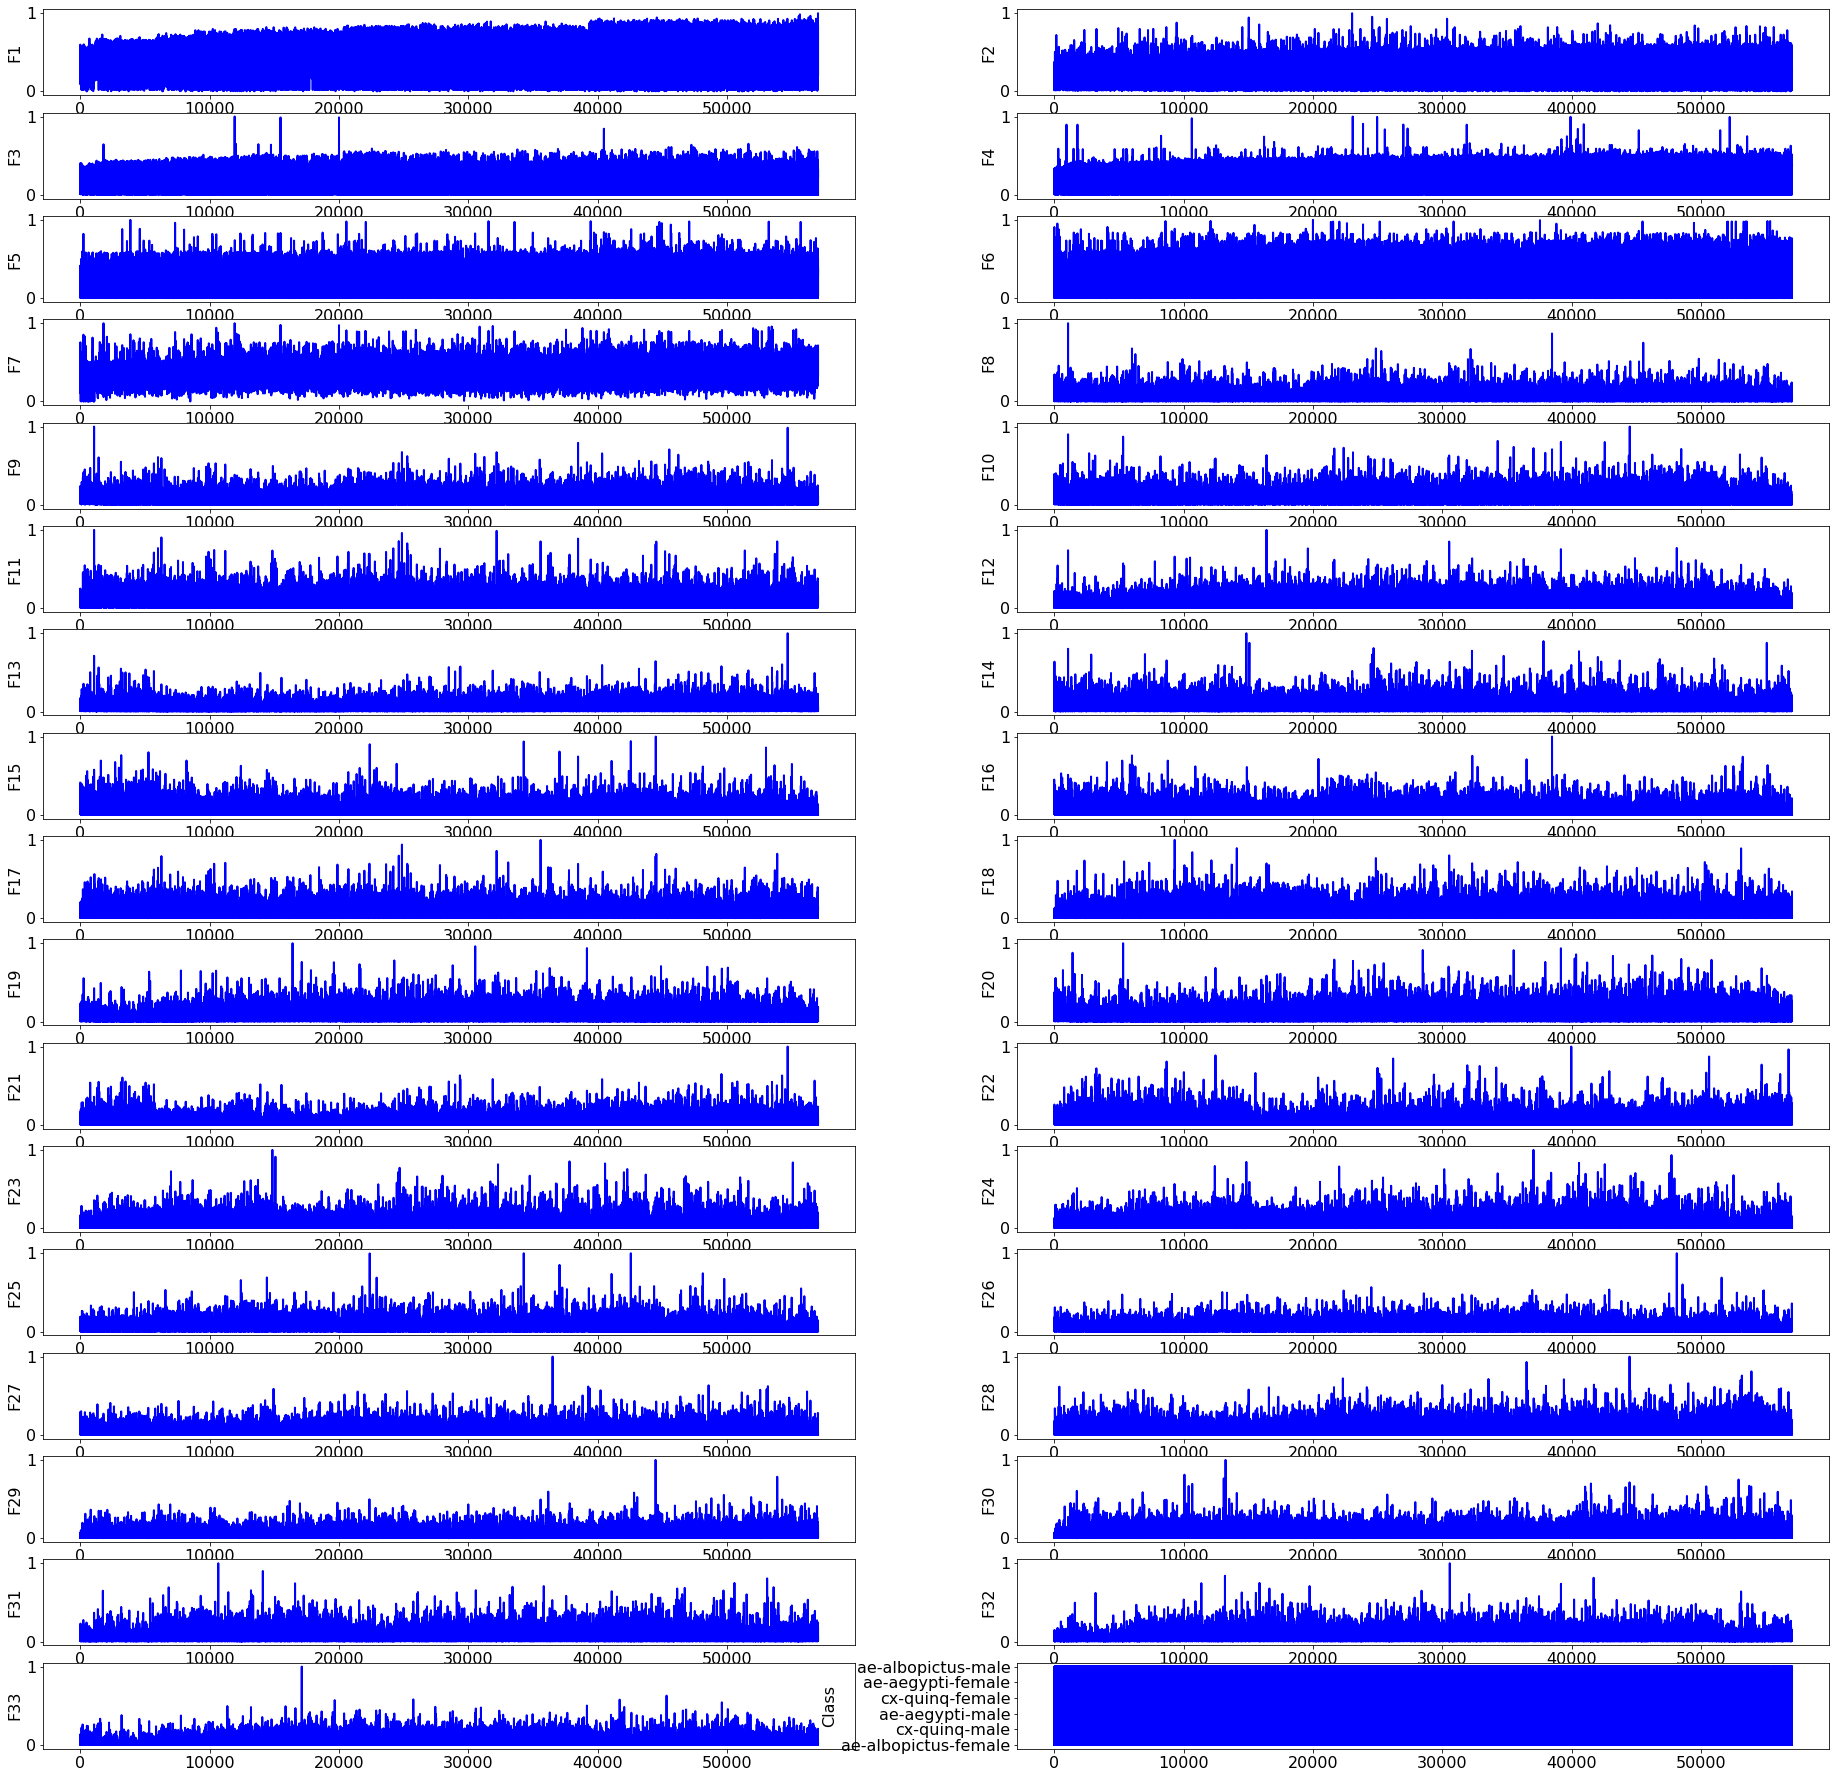

In [79]:
plt.figure(figsize=(32, 32))
plt.rcParams.update({'font.size': 16})
cols = dataset.columns
for i in range(dataset.shape[1]):
    plt.subplot(17, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()

------------------------------------------
## Adaptive Linear Eigen Decomposition
### Using Semi-Stationary Components Only


In [81]:
dataset2 = dataset.drop(['F1','F2', 'F3', 'F4','F7','F8','F9','F10','F11','F32','F33','Class'], 1)
#dataset2 = dataset[['F5','F6','F7', 'F8']].copy()
print(dataset2.shape)
print(dataset2.head())


(57018, 22)
         F5        F6       F12       F13       F14       F15       F16  \
0  0.260262  0.313684  0.096811  0.014780  0.034073  0.410446  0.223038   
1  0.028435  0.164292  0.028445  0.025069  0.020240  0.029956  0.061106   
2  0.206219  0.260224  0.157789  0.129240  0.133627  0.118952  0.077244   
3  0.280583  0.335924  0.142865  0.072600  0.011527  0.100816  0.450355   
4  0.027673  0.239377  0.015527  0.083943  0.015211  0.024276  0.011114   

        F17       F18       F19  ...       F22       F23       F24       F25  \
0  0.087762  0.031736  0.010040  ...  0.015796  0.006302  0.035065  0.184005   
1  0.053038  0.024743  0.015615  ...  0.014593  0.010509  0.009581  0.008929   
2  0.065488  0.059544  0.039587  ...  0.035581  0.030603  0.034363  0.030383   
3  0.203471  0.074477  0.037103  ...  0.032548  0.040863  0.009922  0.032920   
4  0.006899  0.004903  0.007988  ...  0.043699  0.009824  0.008164  0.007628   

        F26       F27       F28       F29       F30     

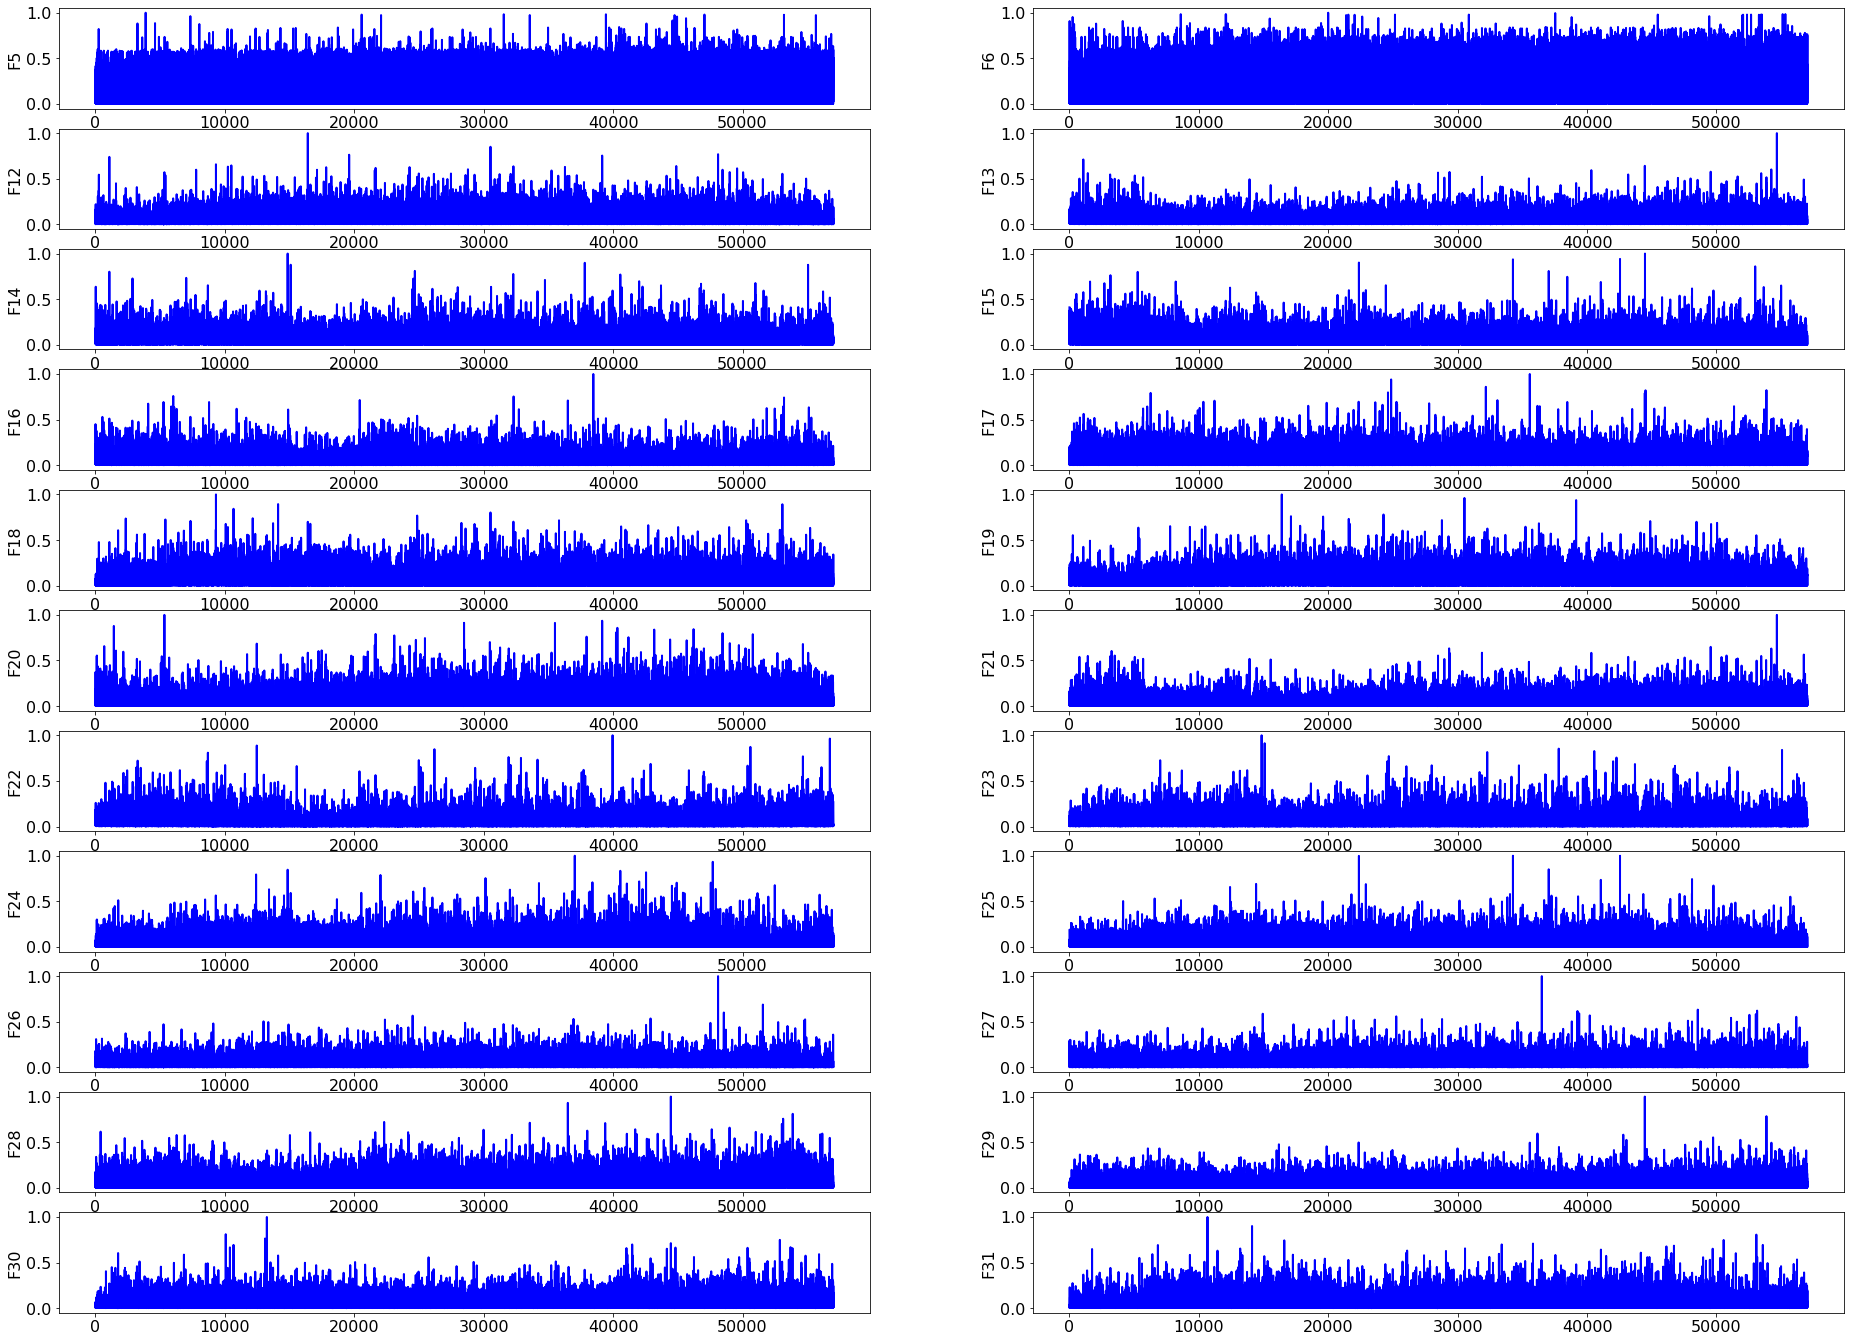

In [82]:
plt.figure(figsize=(32, 24))
plt.rcParams.update({'font.size': 16})
cols = dataset2.columns
n = dataset2.shape[1]//2
for i in range(dataset2.shape[1]):
    plt.subplot(n, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset2[cols[i]], lw=2, color='b')
plt.show()


In [83]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset2.shape[0]
nDim = dataset2.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset2.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(10 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
#print("W=\n", W)


In [84]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [3.51201038e-05 5.04986048e-05 8.77973432e-05 1.00513313e-04
 1.15946261e-04 1.36084376e-04 2.05719946e-04 4.59010903e-04
 5.78736957e-04 8.07084863e-04 9.46317188e-04 1.36587926e-03
 1.64361673e-03 2.86227584e-03 3.54049758e-03 8.98144426e-03
 1.02195771e-02 1.11053752e-02 1.29496967e-02 2.11575973e-02
 3.23494360e-02 2.49290257e-01]
Diags of WTAW
[0.17218677745887864, 0.0657119862891738, 0.03200736482902489, 0.01780318533343627, 0.01073609195858922, 0.006828777272766483, 0.004511881822452059, 0.0030727281685387245, 0.0021525908117376977, 0.0015561077061546928, 0.0011700418102824988, 0.0009253476739555487, 0.0007781164347763668, 0.0006994131523383559, 0.0006695787711294761, 0.0006748970025279887, 0.0007055723592836641, 0.0007544642507794763, 0.0008162722201207795, 0.0008869985789366029, 0.0009635861912082889, 0.0010436694823612175]
Diags of WTW
[0.7925536326296012, 0.33065237356170457, 0.1810933053658025, 0.116756115412585, 0.08416508105103214, 0.06587489619518157, 0.05490637

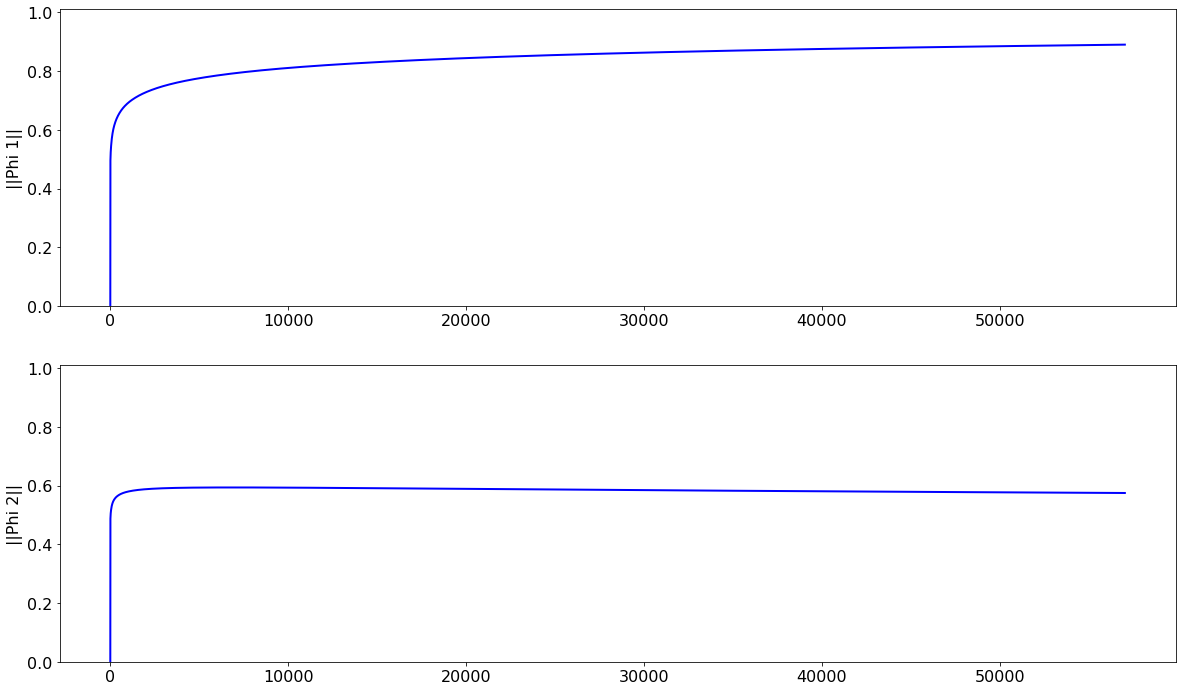

In [85]:
cols = dataset2.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3]})

plt.figure(figsize=(20, 12))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.ylim([0,1.01])
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()

------------------------------------------
## Adaptive Linear Eigen Decomposition
### Using all Non Stationary Components


In [86]:
dataset1 = dataset.drop('Class', 1) #.iloc[0:10000]
print(dataset1.shape)
print(dataset1.head())


(57018, 33)
         F1        F2        F3        F4        F5        F6        F7  \
0  0.162919  0.223581  0.170982  0.210447  0.260262  0.313684  0.210527   
1  0.179910  0.015617  0.018342  0.111462  0.028435  0.164292  0.105495   
2  0.093009  0.171964  0.103600  0.193611  0.206219  0.260224  0.183089   
3  0.364570  0.120045  0.186800  0.226773  0.280583  0.335924  0.229092   
4  0.257008  0.353529  0.007418  0.330596  0.027673  0.239377  0.283919   

         F8        F9       F10  ...       F24       F25       F26       F27  \
0  0.129912  0.108045  0.314143  ...  0.035065  0.184005  0.107587  0.029085   
1  0.085920  0.079683  0.048566  ...  0.009581  0.008929  0.016024  0.024117   
2  0.275424  0.240193  0.236459  ...  0.034363  0.030383  0.024538  0.023142   
3  0.217283  0.212943  0.101705  ...  0.009922  0.032920  0.181381  0.292963   
4  0.036563  0.088543  0.056334  ...  0.008164  0.007628  0.009555  0.005842   

        F28       F29       F30       F31       F32     

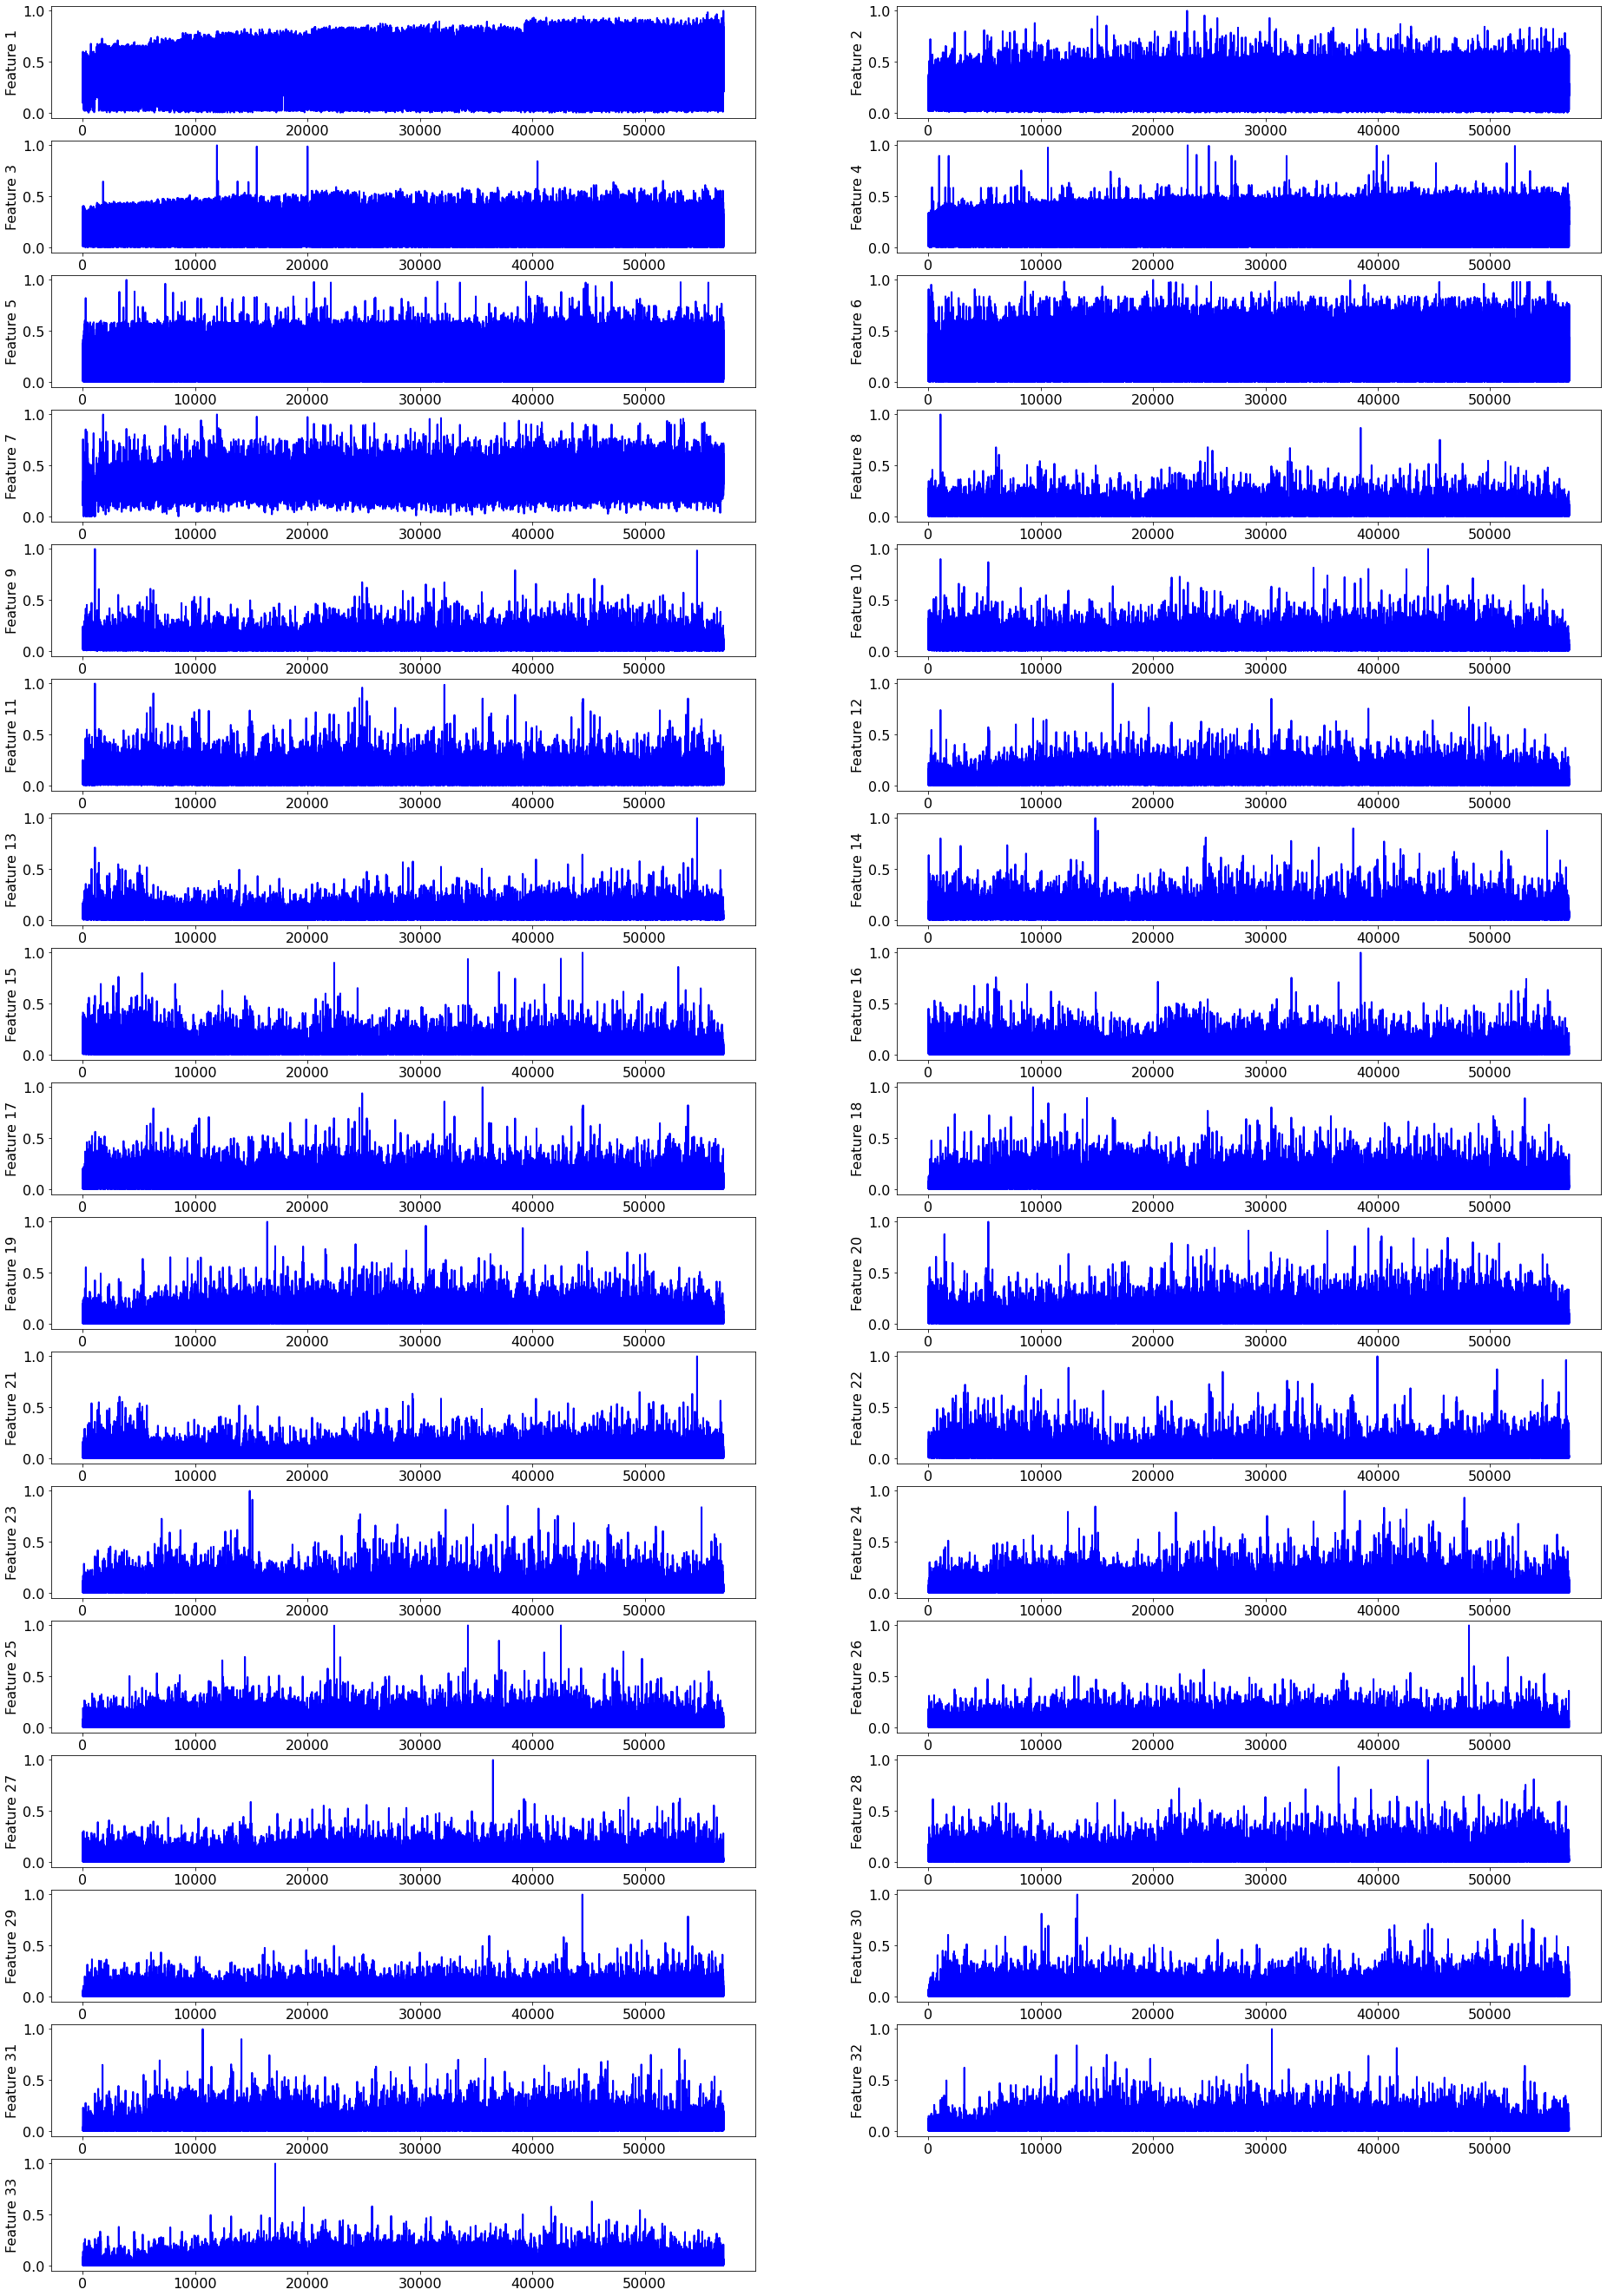

In [87]:
plt.figure(figsize=(32, 48))
plt.rcParams.update({'font.size': 16})
cols = dataset1.columns
for i in range(dataset1.shape[1]):
    plt.subplot(17, 2, i+1)
    plt.ylabel('Feature {}'.format(i+1))
    plt.plot(dataset1[cols[i]], lw=2, color='b')
plt.show()


In [88]:
# Adaptive algorithm
from numpy import linalg as la

nSamples = dataset1.shape[0]
nDim = dataset1.shape[1]

A = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
N = np.zeros(shape=(1,nDim)) # stores eigen norms
W = 0.1 * np.ones(shape=(nDim,nDim)) # stores adaptive eigenvectors
for iter in range(nSamples//1):
    cnt = iter + 1
    x = np.array(dataset1.iloc[iter])
    x = x.reshape(nDim,1)
    A = A + (1.0/cnt)*((np.dot(x, x.T)) - A)
    etat = 1.0/(25 + cnt)
    # Deflated Gradient Descent
    W = W + etat*(A @ W - 0.5*W @ np.triu(W.T @ A @ W) - 0.5*A @ W @ np.triu(W.T @ W))
    newnorm = la.norm(W, axis=0)
    N = np.vstack([N, newnorm])
print("W=\n", W)


W=
 [[ 0.41821946  0.1222987   0.04375558 ... -0.03964109 -0.03767806
  -0.03576032]
 [ 0.31722017  0.10098497  0.04385676 ... -0.02675675 -0.02573048
  -0.02473032]
 [ 0.26149719  0.08602449  0.04015781 ... -0.00867901 -0.00776423
  -0.00687134]
 ...
 [ 0.05919696  0.03903199  0.03756357 ...  0.05258892  0.05249174
   0.05239388]
 [ 0.0569374   0.03820675  0.03684642 ...  0.05151149  0.05143262
   0.0513541 ]
 [ 0.05073105  0.03617036  0.03569045 ...  0.05197151  0.05190714
   0.05184402]]


In [89]:
import math
from scipy.linalg import eigh
WTW = W.T @ W
WTAW = W.T @ A @ W
#print("WTW=\n", WTW)
#print("WTAW=\n", WTAW)
eigvals, eigvecs = eigh(A)
#print("PHI=\n", eigvecs)
print("Lambda=\n", eigvals)
print("Diags of WTAW")
print([WTAW[i,i] for i in range(len(WTAW[0]))])
print("Diags of WTW")
print([WTW[i,i] for i in range(len(WTW[0]))])


Lambda=
 [2.02315212e-05 2.69335835e-05 4.10994927e-05 5.22876413e-05
 7.92296936e-05 8.87349798e-05 1.03318257e-04 1.09047208e-04
 1.71233222e-04 1.90953458e-04 2.27952491e-04 4.00616549e-04
 5.98600405e-04 6.61989486e-04 7.36933569e-04 9.75606113e-04
 1.20000004e-03 1.50697038e-03 2.60117743e-03 2.81830531e-03
 3.19967621e-03 4.21711198e-03 9.64870590e-03 1.10621077e-02
 1.21340540e-02 1.46453875e-02 1.69738804e-02 1.81426979e-02
 2.24805257e-02 2.99030630e-02 3.19204773e-02 3.81095095e-02
 7.16697169e-01]
Diags of WTAW
[0.6998149307784278, 0.07842147880023505, 0.01866212764729959, 0.005332971297933926, 0.0016975563278324177, 0.0010469339608773648, 0.0014841999222038617, 0.0023116993412005487, 0.003225563719898053, 0.0040806492000510855, 0.004807244628578403, 0.005376238583629707, 0.0057820657951090666, 0.006033077647163039, 0.0061454969801790285, 0.006139402727261951, 0.0060360357774688015, 0.005856042161166473, 0.005618402307612272, 0.005339858705934979, 0.005034694183236417, 0.004

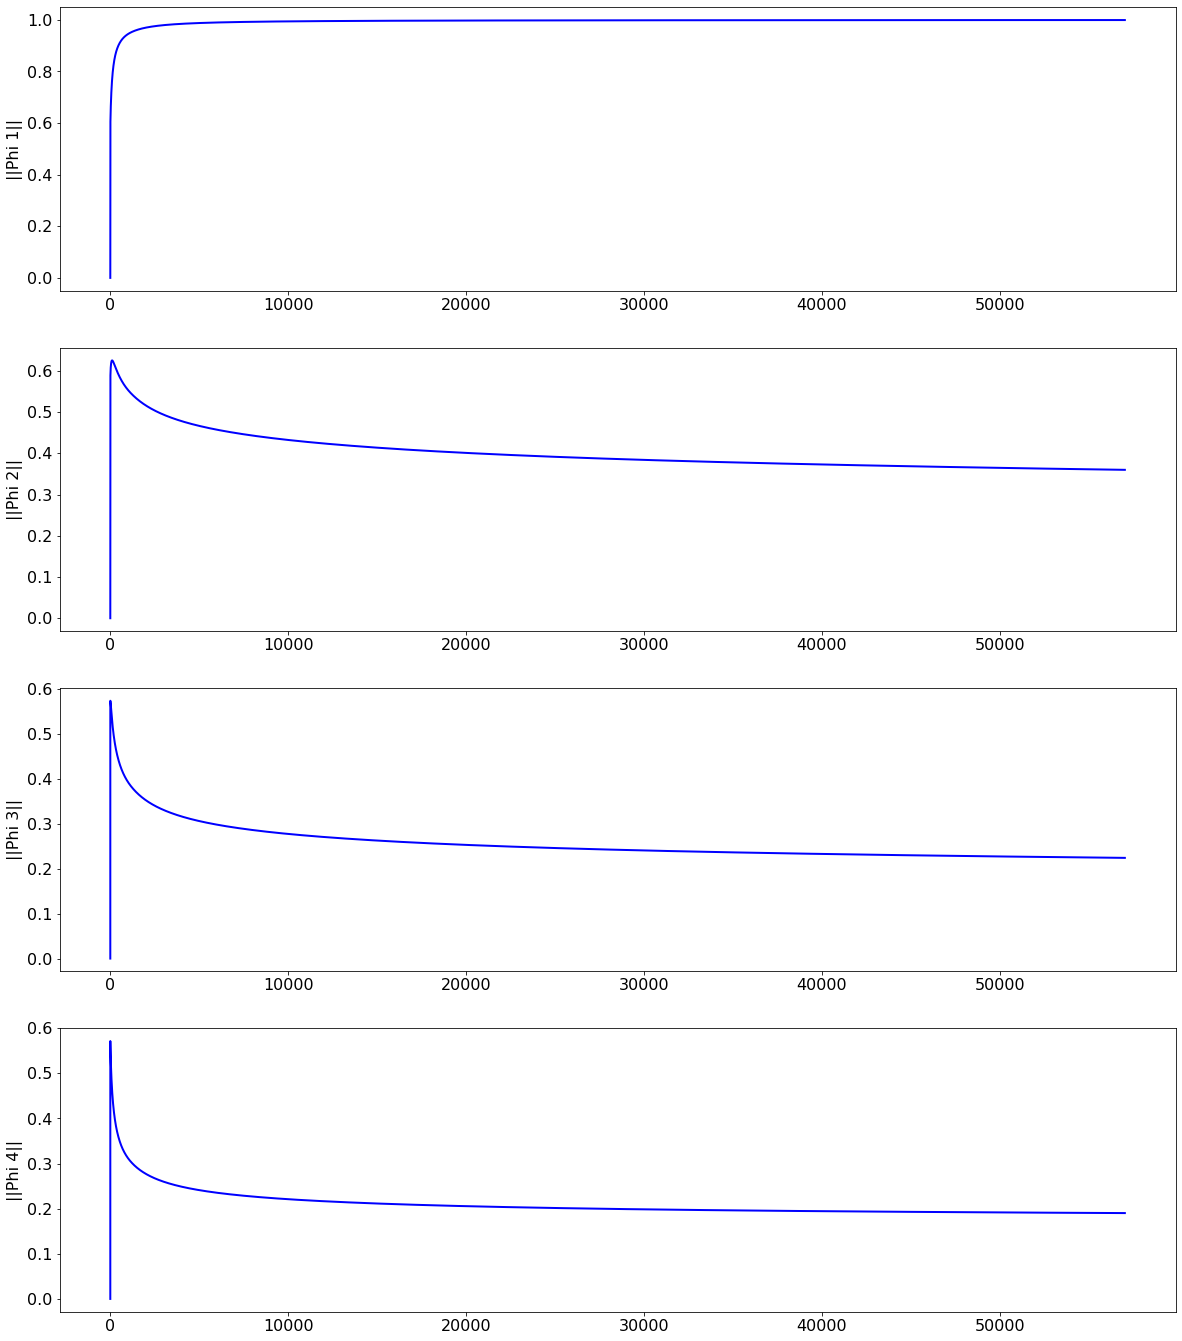

In [90]:
cols = dataset.columns
norms = pd.DataFrame({cols[0]: N[:, 0], cols[1]: N[:, 1], cols[2]: N[:, 2], cols[3]: N[:, 3], \
                      cols[4]: N[:, 4], cols[5]: N[:, 5], cols[6]: N[:, 6], cols[7]: N[:, 7]})

plt.figure(figsize=(20, 24))
plt.rcParams.update({'font.size': 16})
cols = norms.columns
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.ylabel('||Phi {}||'.format(i+1))
    plt.plot(norms[cols[i]], lw=2, color='b')
plt.show()